In [69]:
import os
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn.functional as F
from torchvision import transforms 
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertLMHeadModel, ViTModel, BertConfig, AdamW, ViTConfig

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##### Chest X-Ray dataset

In [4]:
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data_frame['filename'].iloc[index])
        caption = self.data_frame['impression'].iloc[index]

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, caption

In [15]:
image_dir = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\Indiana University - Chest X-Rays\images\images"
image_caption_csv_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\Indiana University - Chest X-Rays\indiana_chest_xray_captions.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

chestxray_dataset = ChestXrayDataset(csv_file=image_caption_csv_path, img_dir=image_dir, transform=transform)
chestxray_dataloader = DataLoader(chestxray_dataset, batch_size=8, shuffle=True)

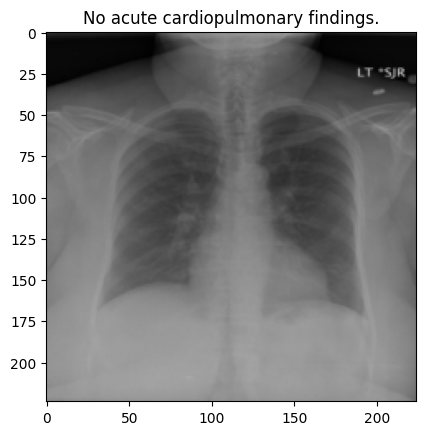

In [18]:
image, caption = chestxray_dataset.__getitem__(10)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{caption}")
plt.show()

##### VQA-RAD Dataset

In [76]:
class VQA_RAD_Dataset(Dataset):
    def __init__(self, json_dir, img_dir, transform=None):

        with open(json_dir, 'r') as file:
            self.data = json.load(file)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data[index]['image_name'])
        question = self.data[index]['question']
        answer = str(self.data[index]['answer'])

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [77]:
image_dir = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\VQA_RAD\VQA_RAD Image Folder"
json_dir = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\VQA_RAD\VQA_RAD Dataset Public.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

vqa_dataset = VQA_RAD_Dataset(json_dir=json_dir, img_dir=image_dir, transform=transform)

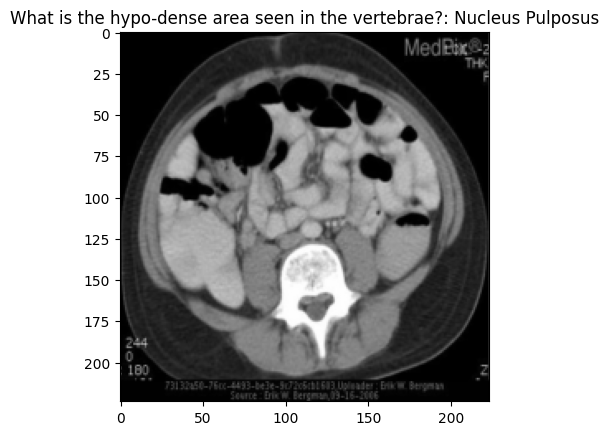

In [78]:
image, question, answer = vqa_dataset.__getitem__(-1)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{question}: {answer}")
plt.show()

##### Loading pre-trained weights (BERT and ViT)

In [2]:
def load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load pre-trained BERT and Vision Transformer models from the pre-training stage.
    
    Inputs:
    - bert_checkpoint_path: Path to the BERT model checkpoint
    - vit_checkpoint_path: Path to the Vision Transformer model checkpoint 
    - device: Device to load models onto, 'cuda' or 'cpu'
    
    Returns:
    - bert_model: Loaded BERT model with pre-trained weights.
    - vit_model: Loaded Vision Transformer model with pre-trained weights.
    """
    
    bert_config = BertConfig.from_pretrained('bert-base-uncased')
    bert_model = BertModel(bert_config)
    bert_checkpoint = torch.load(bert_checkpoint_path, map_location=device)
    bert_model.load_state_dict(bert_checkpoint)
    bert_model.to(device)
    bert_model.eval() 

    vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = ViTModel(vit_config)
    vit_checkpoint = torch.load(vit_checkpoint_path, map_location=device)
    vit_model.load_state_dict(vit_checkpoint)
    vit_model.to(device)
    vit_model.eval()  

    return bert_model, vit_model

In [7]:
bert_checkpoint_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\bert_model_checkpoint.pth"
vit_checkpoint_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\image_encoder_checkpoint.pth"

bert, vit = load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device=device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

##### Masked Langauge Model Inference

In [9]:
from src.components.mlm import MaskedLanguageModeling

In [ ]:
def display_mlm_inference(mlm_model, data_loader, tokenizer, device):
    images, captions = next(iter(data_loader))
    images = images.to(device)
    tokenized_text = tokenizer(captions, return_tensors="pt", padding=True, truncation=True).to(device)

    original_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in tokenized_text["input_ids"]]

    masked_input_ids, labels = mlm_model.mask_tokens(tokenized_text['input_ids'].clone())
    masked_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in masked_input_ids]

    with torch.no_grad():
        text_predictions, _ = mlm_model(images, {"input_ids": masked_input_ids, "attention_mask": tokenized_text["attention_mask"]})

    predicted_texts = []
    for batch_idx in range(text_predictions.size(0)):
        predicted_tokens = torch.argmax(text_predictions[batch_idx], dim=-1)
        predicted_text = tokenizer.decode(predicted_tokens, skip_special_tokens=True)
        predicted_texts.append(predicted_text)

    for idx in range(len(images)):
        image_np = images[idx].cpu().permute(1, 2, 0).numpy()
        plt.figure(figsize=(6, 6))
        
        plt.imshow(image_np)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()

        print(f"Original Text: {original_texts[idx]}")
        print(f"Masked Text: {masked_texts[idx]}")
        print(f"Predicted Text: {predicted_texts[idx]}\n")
        print("-" * 50)

In [ ]:
def visualize_mlm_inference(mlm_model, image, caption, tokenizer, device):
    image = image.to(device).unsqueeze(0)
    tokenized_text = tokenizer(caption, return_tensors="pt", padding=True, truncation=True).to(device)
    
    original_text = tokenizer.decode(tokenized_text["input_ids"][0], skip_special_tokens=False)
    
    masked_input_ids, labels = mlm_model.mask_tokens(tokenized_text['input_ids'].clone())
    masked_text = tokenizer.decode(masked_input_ids[0], skip_special_tokens=False)
    
    with torch.no_grad():
        text_predictions, _ = mlm_model(image, {"input_ids": masked_input_ids, "attention_mask": tokenized_text["attention_mask"]})
    
    predicted_tokens = torch.argmax(text_predictions[0], dim=-1)
    predicted_text = tokenizer.decode(predicted_tokens, skip_special_tokens=True)
    
    image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image_np)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()
    
    print("Original Text:", original_text)
    print("Masked Text:", masked_text)
    print("Predicted Text:", predicted_text)
    print("-" * 50)

In [19]:
mask_token_id = tokenizer.mask_token_id
pad_token_id = tokenizer.pad_token_id

mlm_model = MaskedLanguageModeling(
    bert_model=bert,
    image_encoder=vit,
    mask_token_id=mask_token_id,
    pad_token_id=pad_token_id
).to(device)

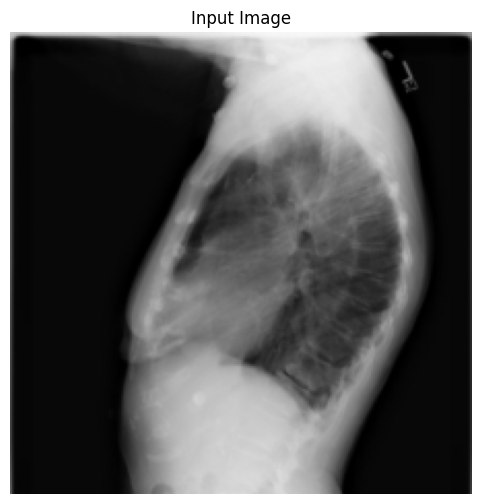

Original Text: there is no evidence of acute cardiopulmonary disease..
Masked Text: there no evidence of acute cardiopulmonary..
Predicted Text: unseen medication medieval瀬iner hades kiel fluentsco escorting fulfillingmori dentistryps participating limitation dentistry volleyball pepsi pepsi freeman pathetic pathetic pathetic pathetic pathetic pathetic pathetic landmarks pathetic emil pathetic pathetic freeman freeman pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic emil emil emil emil pathetic pathetic freeman pepsi dentistry dentistry dentistry dentistry pepsi quit pathetic pathetic nedra pathetic pathetic pathetic pepsi pepsi pepsi freeman pepsi

--------------------------------------------------


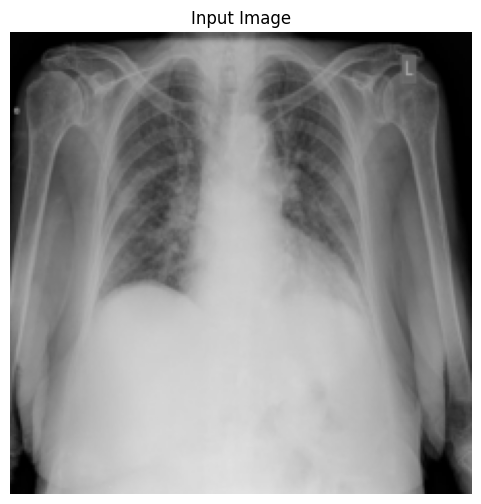

Original Text: 1. cardiomegaly with diffuse interstitial opacities. findings may be secondary to pulmonary edema. atypical infection is another consideration.
Masked Text: 1. cardegaly with diffuse interstitial opacities. findings be secondary to pulmonary ed.ypical infection is another consideration.
Predicted Text: unseenbered amar utmost lesions emil campaign inclusion ಾ paired cr clutching rear finn dentistry inclusionう blushed ya 1400 dna section counterparts fatty dentistry conditioning continental pepsi schultz bertchua appendix limitation dentistry pathetic pepsi dentistry dentistry dentistry dentistry dentistry dentistry pathetic pathetic pathetic pathetic restoration pepsi pathetic pathetic pathetic pathetic pathetic locker pathetic emil emil emil emil pathetic pathetic pepsi pepsi dentistry pepsi dentistry dentistry dentistry dentistry pepsi pepsi pepsi freeman pathetic [unused948] pepsi dentistry freeman [unused948] freeman

-------------------------------------------------

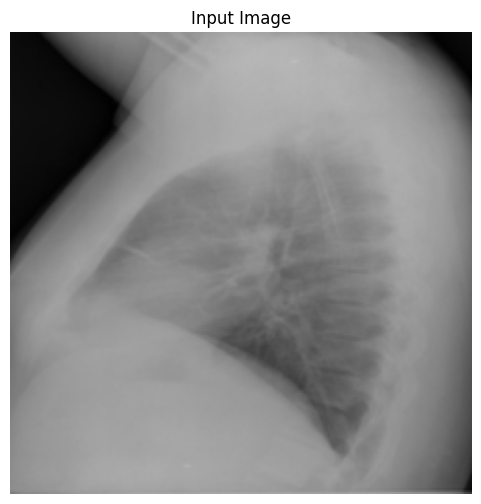

Original Text: normal chest
Masked Text: normal chest
Predicted Text: waved civilians jiangsu dentistrycock pathetic freeman dentistry dentistry dentistry dentistry dentistry dentistry dentistry freeman pepsi pepsi pepsi [unused948] [unused948] pathetic pathetic pathetic pathetic pathetic pathetic pathetic 510 510 darren darren pathetic pathetic pathetic pathetic pathetic pepsi quit quit pepsi quit skins skins skins pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic darren emil emil emil pathetic pathetic pathetic pathetic pathetic skins quit quit skins skins skins skins skins skins skins [unused948] [unused948] ☉ [unused948] [unused948] [unused948]

--------------------------------------------------


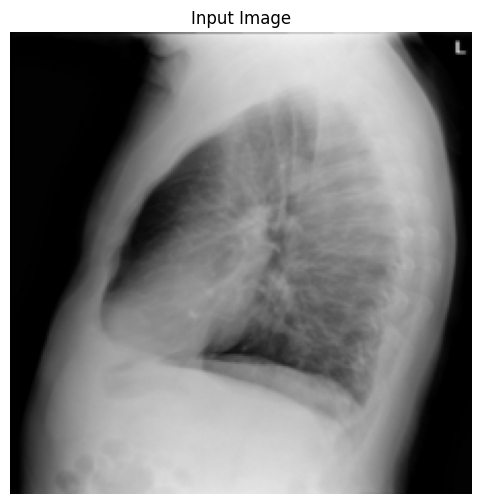

Original Text: no acute cardiopulmonary process.
Masked Text: no acute cardpulmona process.
Predicted Text: waved anywhere constructive fluentsco escorting banded effortlessly parent send limitation dentistry domino pepsi freeman pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pepsi pathetic pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic darren emil emil emil pathetic pathetic pathetic freeman pepsi restoration pepsi pepsi pepsi quit pathetic pathetic pathetic pathetic pathetic [unused948] pathetic pepsi [unused948] pathetic [unused948]

--------------------------------------------------


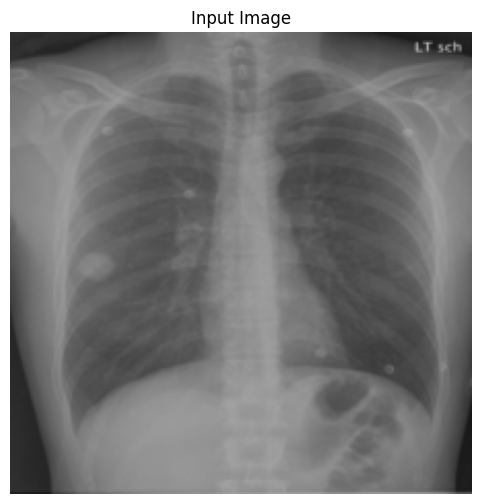

Original Text: heart size is normal. 2 cm calcified granuloma in the right midlung. calcified right hilar lymph xxxx. no other nodules or masses. it is unchanged xxxx compared to a xxxx for the abdomen ct scan from xxxx. the xxxx 40 % of the nodule is on the upper portion of the xxxx film.
Masked Text: heart size is normal. 2 cm calcified granulo in the right midlung. calfied hilar lymph xxxx. no nodules or masses. it is unchanged xxxx compared xxxx for the abdomen ct scan xxxx. the xx % of the nodule is on the upper portion the xxxx.
Predicted Text: unseen surprisedalis sticky fences dentistry enrique brusselsemonhit barnard recurringbib endings enrique reserveges admits bala reserve dentistry ann franklin barnard lucien controllers weakness skins recurring nba ropesaux dentistry reginald introductory stones₅ geoff dario dentistry fleetstsu 1737 weakness forearms starting monument geoff voting robinson geoff reserve nba 、 、 circuits ropesaux dentistry enrique voting dna raion townland

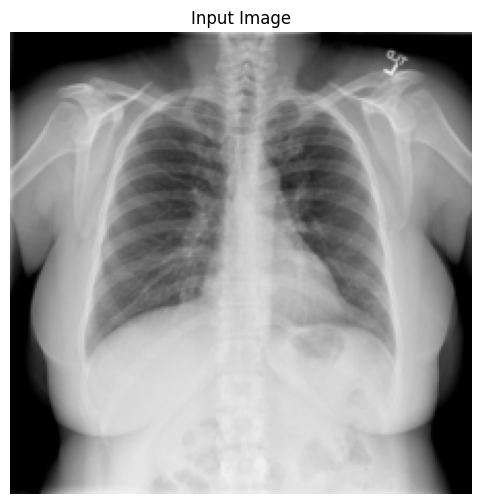

Original Text: no acute process.
Masked Text: no acute process.
Predicted Text: unseen moralscript civilians limitation pepsi [unused208] pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi freeman pathetic pathetic pathetic pathetic pathetic landmarks landmarks pathetic pathetic pathetic pathetic pathetic pathetic pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic 6th pathetic pathetic pathetic emil emil pathetic pathetic pathetic pathetic pathetic ann pepsi pepsi pepsi ann pathetic pathetic gnome pathetic pathetic [unused948] [unused948] freeman [unused948] pathetic [unused948]

--------------------------------------------------


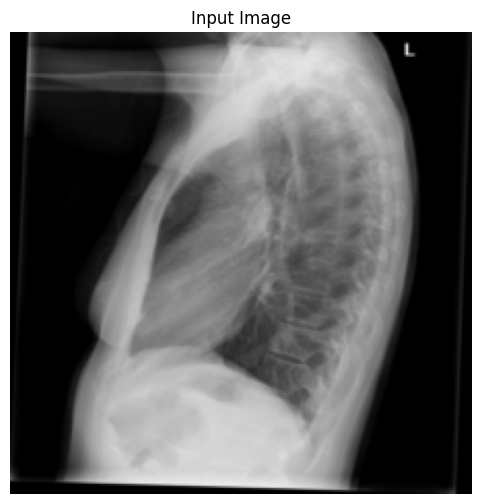

Original Text: no acute disease.
Masked Text: no acute disease.
Predicted Text: unseen瀬 civilians fabricated limitation pepsi [unused208] pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic landmarks pathetic pathetic pathetic pathetic pepsi freeman pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic freeman freeman pepsi pepsi pepsi pepsi pathetic pathetic undrafted pathetic pathetic [unused948] [unused948] undrafted [unused948] pathetic [unused948]

--------------------------------------------------


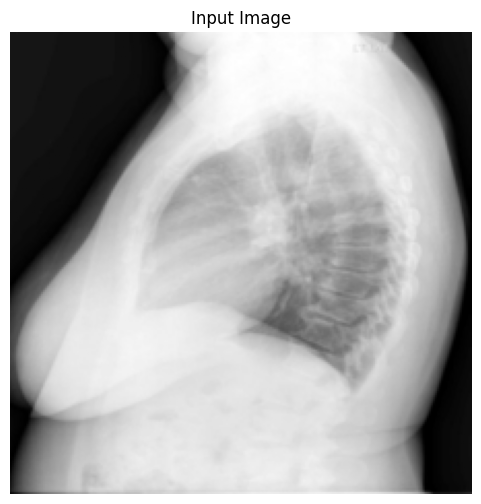

Original Text: 1. no acute pulmonary disease.
Masked Text: . no acute pulmonary.
Predicted Text: unseenbered astronomers tuition sectionʌ fabricated jiangsu pepsi [unused208] pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic landmarks landmarks landmarks pathetic pathetic pathetic pathetic pathetic pepsi pepsi pepsi pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic pathetic emil emil emil pathetic pathetic pathetic freeman pepsi freeman pepsi pepsi pepsi pepsi pathetic pathetic pathetic pathetic pathetic pathetic freeman pepsi [unused948] pathetic [unused948]

--------------------------------------------------


In [30]:
display_mlm_inference(mlm_model, chestxray_dataloader, tokenizer, device)

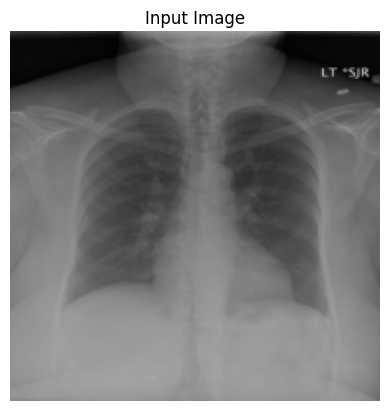

Original Text: [CLS] no acute cardiopulmonary findings. [SEP]
Masked Text: [CLS] no acute card [MASK] [MASK]lmonary findings. [SEP]
Predicted Text: unseen瀬 constructive fluentsco escorting uncles hazardous dentistry send limitation dentistry
--------------------------------------------------


In [29]:
image, caption = chestxray_dataset.__getitem__(10)
visualize_mlm_inference(mlm_model, image, caption, tokenizer, device)

##### Masked Image Model Inference  

In [31]:
from src.components.mim import MaskedImageModeling

In [ ]:
def visualize_mim_inference(mim_model, image, device, mask_probability=0.15):
    mim_model.eval()  
    
    image = image.unsqueeze(0).to(device) 
    
    with torch.no_grad():
        reconstructed_patches, mask = mim_model(image, mask_probability=mask_probability)
    
    original_patches = mim_model.patchify(image)
    
    mask = mask.unsqueeze(-1).expand_as(original_patches)
    masked_image_patches = original_patches * (~mask)
    masked_image = unpatchify(masked_image_patches, mim_model.patch_size, image.shape[-2:])
    
    reconstructed_image_patches = original_patches * (~mask) + reconstructed_patches * mask
    reconstructed_image = unpatchify(reconstructed_image_patches, mim_model.patch_size, image.shape[-2:])

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(ToPILImage()(image.squeeze(0).cpu()))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(ToPILImage()(masked_image.squeeze(0).cpu()))
    ax[1].set_title("Masked Image")
    ax[1].axis("off")
    
    ax[2].imshow(ToPILImage()(reconstructed_image.squeeze(0).cpu()))
    ax[2].set_title("Reconstructed Image (Masked Patches)")
    ax[2].axis("off")
    plt.show()

def unpatchify(patches, patch_size, image_size):
    B, num_patches, _ = patches.shape
    C = patches.shape[-1] // (patch_size * patch_size)
    H, W = image_size
    
    patches = patches.view(B, H // patch_size, W // patch_size, patch_size, patch_size, C)
    patches = patches.permute(0, 5, 1, 3, 2, 4) 
    return patches.reshape(B, C, H, W)


In [36]:
mim_model = MaskedImageModeling(vit, hidden_size=vit.embeddings.config.hidden_size, 
                                patch_size=vit.embeddings.config.patch_size).to(device)

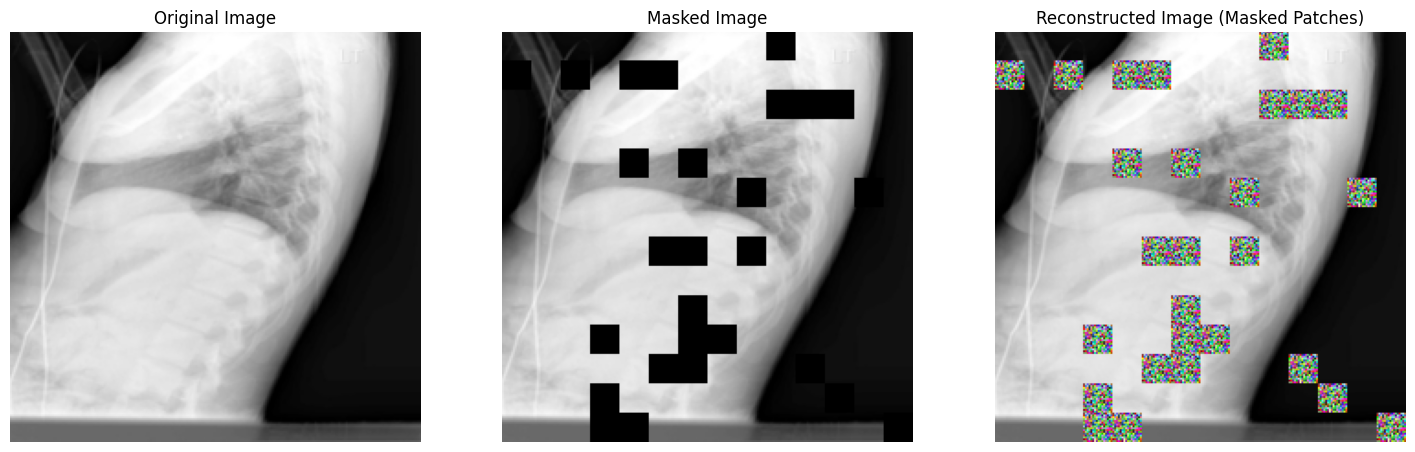

In [42]:
image, caption = chestxray_dataset.__getitem__(-1)
visualize_mim_inference(mim_model, image, device)

##### Image Text Matching Model Inference 

In [43]:
from src.components.itm import ImageTextMatching

In [ ]:
def test_itm_inference(itm_model, data_loader, tokenizer, device):
    itm_model.eval()
    
    images, captions = next(iter(data_loader))
    
    images = images.to(device)

    tokenized = tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
    input_ids = tokenized['input_ids'].to(device)
    attention_mask = tokenized['attention_mask'].to(device)

    with torch.no_grad():
        logits, labels = itm_model(images, input_ids, attention_mask)

    predicted_labels = torch.argmax(logits, dim=1)
    print("Ground Truth Labels:", labels.cpu().numpy())
    print("Predicted Labels:", predicted_labels.cpu().numpy())
    print("Logits:", logits.cpu().numpy())

In [ ]:
def visualize_itm_inference(itm_model, image, caption, tokenizer, device):
    image = image.to(device).unsqueeze(0)  
    tokenized_text = tokenizer(caption, return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        logits, _ = itm_model(
            images=image,
            input_ids=tokenized_text["input_ids"],
            attention_mask=tokenized_text["attention_mask"],
            generate_negatives=False  
        )
    
    probs = F.softmax(logits, dim=-1)  
    prediction = torch.argmax(probs, dim=-1).item() 
    confidence = probs[0, prediction].item() 
    
    # Output the result
    match_label = "Match" if prediction == 1 else "Mismatch"
    print(f"Prediction: {match_label}")
    print(f"Confidence Score: {confidence:.4f}")

In [44]:
itm_model = ImageTextMatching(vit, bert, vit.config.hidden_size).to(device)

In [ ]:
test_itm_inference(itm_model, chestxray_dataloader, tokenizer, device)

Ground Truth Labels: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Predicted Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Logits: [[-0.08772863  0.15504935]
 [-0.08628366  0.15530567]
 [-0.09361298  0.16575246]
 [-0.03843216  0.15116423]
 [-0.08917835  0.16574737]
 [-0.1044144   0.16266337]
 [-0.07591151  0.11096251]
 [-0.12255948  0.16222915]
 [-0.03801222  0.14825407]
 [-0.08628366  0.15530567]
 [-0.08908895  0.1652937 ]
 [-0.07632037  0.11400966]
 [-0.10411712  0.1622945 ]
 [-0.09399962  0.16657497]
 [-0.0877397   0.15491235]
 [-0.12255948  0.16222915]]


Model outputs for Matching image and text pair:
Prediction: Match
Confidence Score: 0.5586


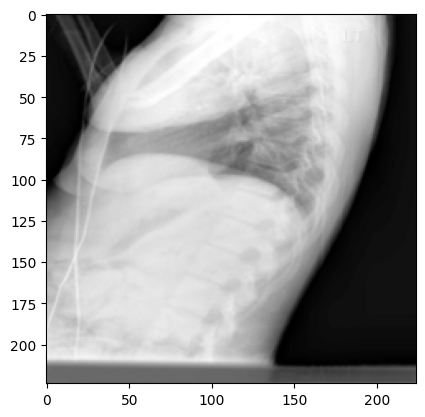

Caption: The cardiac silhouette is normal in size and configuration. The mediastinum and perihilar structures appear unremarkable. The lungs appear clear. The osseous structures are within normal limits.


In [ ]:
image, caption = chestxray_dataset.__getitem__(-1)

print(f"Model output for Matching image and text pair:")
visualize_itm_inference(itm_model, image, caption, tokenizer, device)
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.show()
print(f"Caption: {caption}")

Model output for Non-Matching image and text pair:
Prediction: Match
Confidence Score: 0.5664


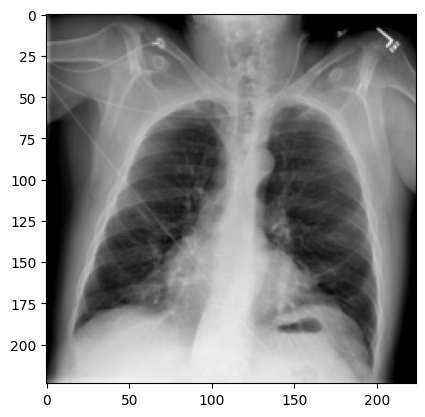

Caption: No acute cardiopulmonary findings.


In [68]:
image1, caption1 = chestxray_dataset.__getitem__(10)
image, caption = chestxray_dataset.__getitem__(-10)

print(f"Model output for Non-Matching image and text pair:")
visualize_itm_inference(itm_model, image, caption1, tokenizer, device)
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.show()
print(f"Caption: {caption1}")

##### Visual Question Answering Model Inference 

In [74]:
from src.components.vqa_model import VQAModel

In [79]:
def display_vqa_single_result(model, image, question, ground_truth_answer, tokenizer, max_answer_length=20, device='cuda'):
    """
    Display the VQA model result for a single image and question, including the generated answer and ground truth answer.

    Parameters:
        model (VQAModel): The VQA model.
        image (torch.Tensor): A single image tensor.
        question (str): The question string.
        ground_truth_answer (str): The ground truth answer for the question.
        tokenizer (BertTokenizer): Tokenizer for encoding the question.
        max_answer_length (int): Maximum length for generated answers.
        device (str): Device to run the model on ('cuda' or 'cpu').
    """
    model.to(device)
    model.eval()

    # Move the image to the device and add a batch dimension
    image = image.unsqueeze(0).to(device)

    # Tokenize the question
    encoding = tokenizer(
        question,
        padding='max_length',
        truncation=True,
        max_length=12,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Initialize the decoder input with the CLS token
    decoder_input_ids = torch.full((1, 1), tokenizer.cls_token_id, device=device)

    # Forward pass through the model to get answer logits
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=image, decoder_input_ids=decoder_input_ids)
        logits = outputs['logits']  # Direct output from the answer decoder

    # Greedy decoding to generate the answer from logits
    generated_answer_tokens = []
    for token_logits in logits[0]:  # Process tokens for the single sample
        next_token_id = token_logits.argmax(dim=-1).item()
        if next_token_id == tokenizer.sep_token_id:
            break
        generated_answer_tokens.append(next_token_id)

    # Decode tokens to text
    generated_answer = tokenizer.decode(generated_answer_tokens, skip_special_tokens=True)

    # Display the image
    image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

    # Display the question, generated answer, and ground truth answer
    print(f"Question: {question}")
    print(f"Generated Answer: {generated_answer}")
    print(f"Ground Truth Answer: {ground_truth_answer}")
    print("-" * 50)

In [85]:
model_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Code Notebooks\vqa_model_checkpoint.pth"

answer_decoder_config = BertConfig.from_pretrained('bert-base-uncased')
answer_decoder_config.is_decoder = True
answer_decoder_config.add_cross_attention = True

vqa_model = VQAModel(bert, vit, answer_decoder_config).to(device)
checkpoint = torch.load(model_path, map_location=device)
vqa_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

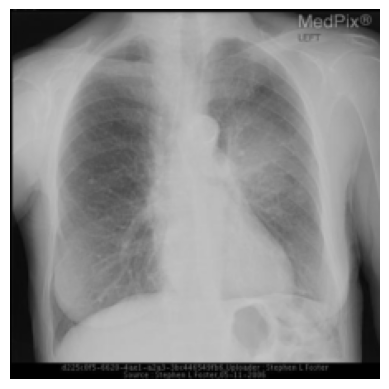

Question: Are the lungs normal appearing?
Generated Answer: no
Ground Truth Answer: No
--------------------------------------------------


In [86]:
image, question, answer = vqa_dataset.__getitem__(1)
display_vqa_single_result(vqa_model, image, question, answer, tokenizer)